<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%205/Google%20Colab/Tugas_Week_5_Tensorflow_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Preprocessing Data

In [67]:
data = pd.read_csv('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv')

In [68]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [69]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [72]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ==== Hyperparameter ====
epochs = 10
num_words = 15000
maxlen = 200
batch_size = 256
embed_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15

In [73]:
# ==== Tentukan kolom yang digunakan ====
review_col = 'Review Text'
rating_col = 'Rating'

# ==== Cek dan isi NaN ====
data[review_col] = data[review_col].fillna("").astype(str)

# ==== Preprocessing Teks ====
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)     # Hapus tanda baca
        text = re.sub(r'\d+', '', text)         # Hapus angka
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w not in stop_words])
    else:
        return ""

data['processed_review'] = data[review_col].apply(preprocess_text)

In [74]:
# ==== Labeling ====
rating_threshold = 3
data['sentiment'] = (data[rating_col] > rating_threshold).astype(int)

# ==== Buat Vocabulary ====
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab[''] = 0
    return vocab

vocabulary = build_vocab(data['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15000


In [75]:
# ==== Convert teks ke sequence ====
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # 0 untuk OOV dan padding
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    else:
        return sequence + [0] * (maxlen - len(sequence))

data['sequence'] = data['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

In [76]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,processed_review,sentiment,sequence
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable,1,"[170, 417, 768, 536, 24, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happened find store im ...,1,"[2, 1, 1506, 47, 1141, 144, 56, 9, 220, 710, 3..."
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hopes dress really wanted work initially ...,0,"[125, 929, 1, 15, 119, 51, 983, 16, 43, 13, 15..."
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ev...,1,"[2, 2, 2, 496, 194, 1131, 646, 221, 111, 7, 58..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering due adjustable front tie perf...,1,"[37, 20, 374, 1011, 93, 364, 18, 35, 7, 185, 1..."


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              23486 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
 11  processed_review         23486 non-null  object
 12  sentiment                23486 non-null  int64 
 13  sequence                 23486 non-null  object
dtypes: int64(7), object(7)
memory usage: 2

In [78]:
# ==== Split Dataset ====
X = np.array(data['sequence'].tolist())
y = np.array(data['sentiment'].tolist())

In [79]:
y

array([1, 1, 0, ..., 0, 0, 1])

In [80]:
Counter(y)

Counter({np.int64(1): 18208, np.int64(0): 5278})

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN Model

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GlobalMaxPooling1D

model_rnn = Sequential()

# Embedding Layer
model_rnn.add(Embedding(vocab_size, embed_dim, mask_zero=False))

# Hidden RNN Layers
for i in range(num_layers - 1):
    model_rnn.add(SimpleRNN(hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

# Last RNN Layer
model_rnn.add(SimpleRNN(hidden_dim,
                    return_sequences=True,
                    dropout=0.3,
                    kernel_initializer='orthogonal',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros'))

# Global Max Pooling
model_rnn.add(GlobalMaxPooling1D())

# Dense + Dropout
model_rnn.add(Dense(128, activation="relu"))
model_rnn.add(Dropout(0.3))

# Output Layer
model_rnn.add(Dense(1, activation='sigmoid',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros'))


In [83]:
model_rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [84]:
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [85]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.7700 - loss: 0.5543 - val_accuracy: 0.7770 - val_loss: 0.5317
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7796 - loss: 0.5337 - val_accuracy: 0.7770 - val_loss: 0.5307
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7796 - loss: 0.5345 - val_accuracy: 0.7770 - val_loss: 0.5302
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7795 - loss: 0.5337 - val_accuracy: 0.7770 - val_loss: 0.5114
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.7780 - loss: 0.4899 - val_accuracy: 0.7770 - val_loss: 0.4828
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7806 - loss: 0.4707 - val_accuracy: 0.7908 - val_loss: 0.4668
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8087 - loss: 0.4377 - val_accuracy: 0.8095 - val_loss: 0.4501
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8268 - loss: 0.4063 - 

In [86]:
y_pred_rnn = model_rnn.predict(X_test)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [87]:
# Evaluasi
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')  # 'micro', 'macro', 'weighted'

print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1-score: {f1_rnn:.4f}")


Accuracy: 0.8223
Precision: 0.8148
Recall: 0.8223
F1-score: 0.8175


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


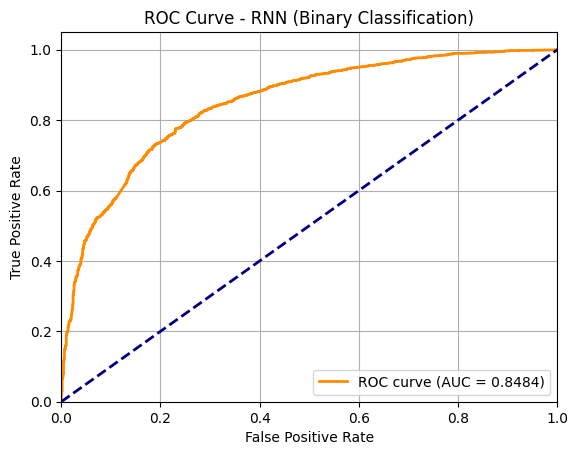

In [88]:
y_prob_rnn = model_rnn.predict(X_test)  # output dari sigmoid, bentuknya (n_samples, 1)
y_prob_rnn = y_prob_rnn.ravel()  # pipihkan dari (n_samples, 1) ke (n_samples,)

# Hitung ROC dan AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

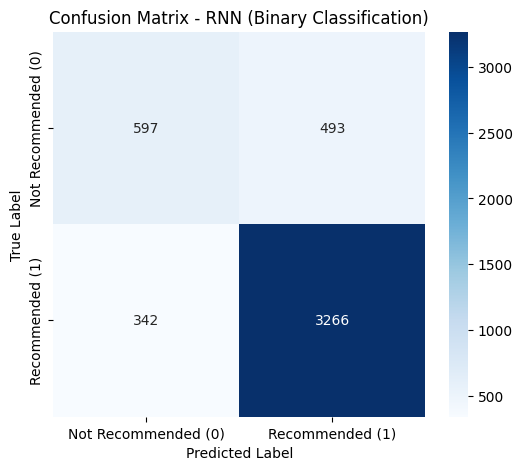

In [89]:
# Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Visualisasi dengan seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RNN (Binary Classification)')
plt.show()

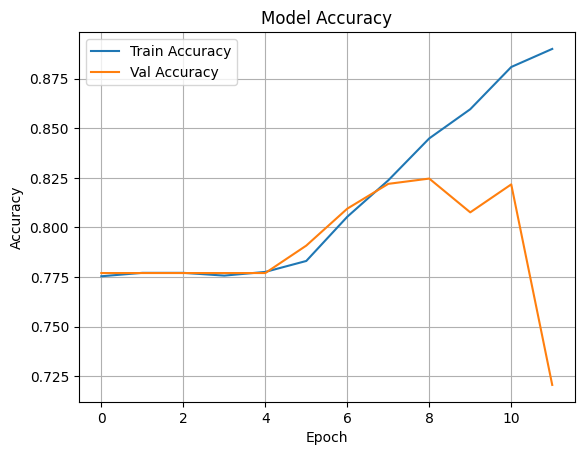

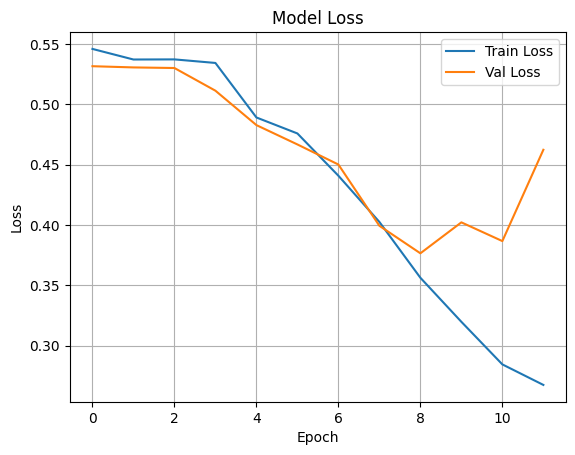

In [90]:
# Akurasi
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model

In [91]:
model_lstm = Sequential()

# Embedding Layer
model_lstm.add(Embedding(vocab_size, embed_dim, mask_zero=False))

# Hidden LSTM Layers
for i in range(num_layers - 1):
    model_lstm.add(LSTM(hidden_dim,
                        return_sequences=True,
                        dropout=0.3,
                        kernel_initializer='orthogonal',
                        recurrent_initializer='orthogonal',
                        bias_initializer='zeros'))

# Last LSTM Layer
model_lstm.add(LSTM(hidden_dim,
                    return_sequences=True,
                    dropout=0.3,
                    kernel_initializer='orthogonal',
                    recurrent_initializer='orthogonal',
                    bias_initializer='zeros'))

# Global Max Pooling
model_lstm.add(GlobalMaxPooling1D())

# Dense + Dropout
model_lstm.add(Dense(128, activation="relu"))
model_lstm.add(Dropout(0.3))

# Output Layer
model_lstm.add(Dense(1, activation='sigmoid',
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'))

In [92]:
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [93]:
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [94]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7853 - loss: 0.4908 - val_accuracy: 0.8656 - val_loss: 0.3175
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8821 - loss: 0.2802 - val_accuracy: 0.8731 - val_loss: 0.3512
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9099 - loss: 0.2237 - val_accuracy: 0.8651 - val_loss: 0.3730
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9349 - loss: 0.1796 - val_accuracy: 0.8624 - val_loss: 0.3845


In [95]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [96]:
# Evaluasi
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

# Output
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

Accuracy: 0.8633
Precision: 0.9023
Recall: 0.9218
F1-score: 0.9120


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


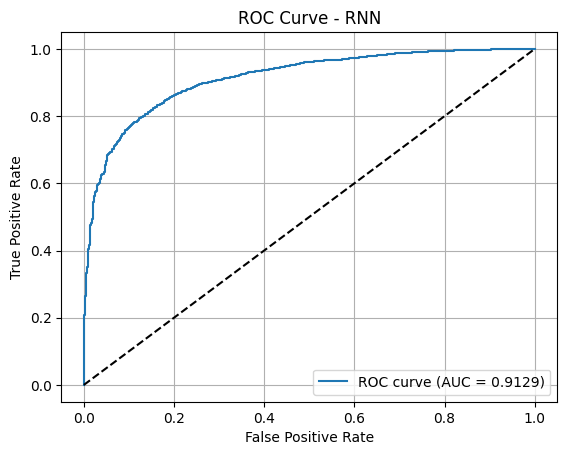

In [97]:
# Dapatkan probabilitas prediksi
y_prob_lstm = model_lstm.predict(X_test).ravel()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

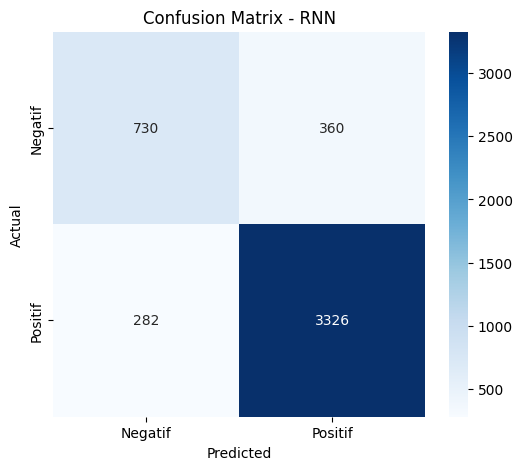

In [98]:
# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

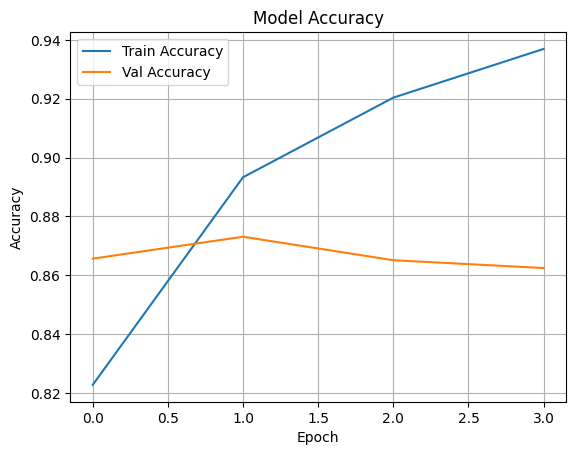

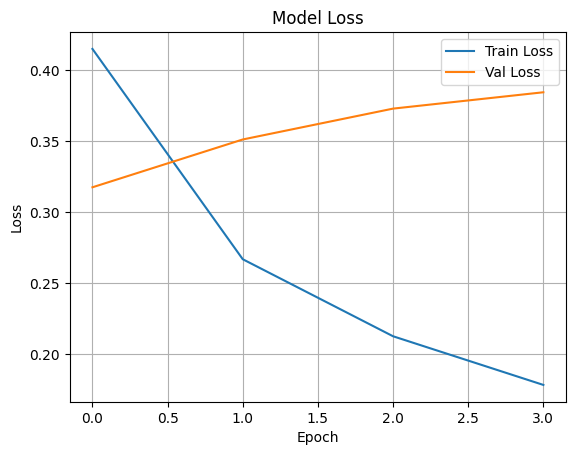

In [99]:
# Akurasi
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

In [100]:
model_gru = Sequential()

# Embedding Layer
model_gru.add(Embedding(vocab_size, embed_dim, mask_zero=False))

# Hidden GRU Layers
for i in range(num_layers - 1):
    model_gru.add(GRU(hidden_dim,
                      return_sequences=True,
                      dropout=0.3,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))

# Last GRU Layer
model_gru.add(GRU(hidden_dim,
                  return_sequences=True,
                  dropout=0.3,
                  kernel_initializer='orthogonal',
                  recurrent_initializer='orthogonal',
                  bias_initializer='zeros'))

# Global Max Pooling
model_gru.add(GlobalMaxPooling1D())

# Dense + Dropout
model_gru.add(Dense(128, activation="relu"))
model_gru.add(Dropout(0.3))

# Output Layer
model_gru.add(Dense(1, activation='sigmoid',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros'))

In [101]:
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [103]:
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7965 - loss: 0.4782 - val_accuracy: 0.8595 - val_loss: 0.3270
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8887 - loss: 0.2754 - val_accuracy: 0.8680 - val_loss: 0.3250
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9159 - loss: 0.2147 - val_accuracy: 0.8592 - val_loss: 0.3851
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9383 - loss: 0.1651 - val_accuracy: 0.8590 - val_loss: 0.4059
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9542 - loss: 0.1320 - val_accuracy: 0.8574 - val_loss: 0.4199


In [104]:
y_pred_gru = model_gru.predict(X_test)
y_pred_gru = (y_pred_gru > 0.5).astype(int)

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [105]:
# Evaluasi
accuracy_gru = accuracy_score(y_test, y_pred_gru)
precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

# Output
print(f"Accuracy: {accuracy_gru:.4f}")
print(f"Precision: {precision_gru:.4f}")
print(f"Recall: {recall_gru:.4f}")
print(f"F1-score: {f1_gru:.4f}")

Accuracy: 0.8676
Precision: 0.8937
Recall: 0.9393
F1-score: 0.9159


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


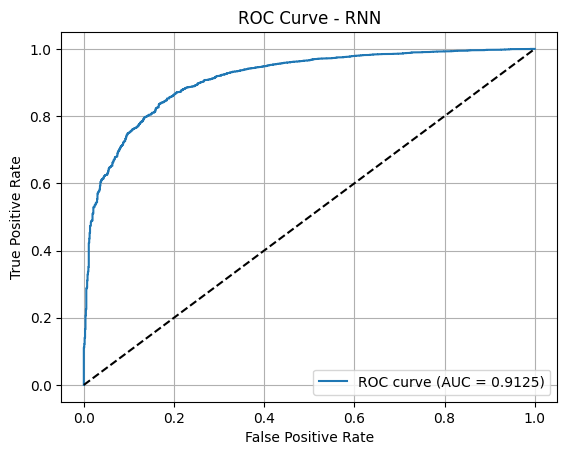

In [106]:
# Dapatkan probabilitas prediksi
y_prob_gru = model_gru.predict(X_test).ravel()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gru)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

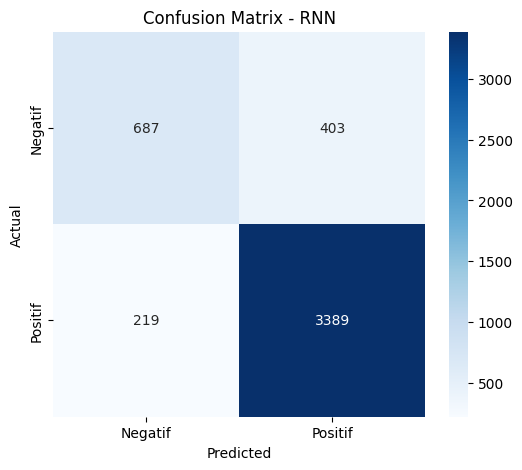

In [107]:
# Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Visualisasi pakai seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

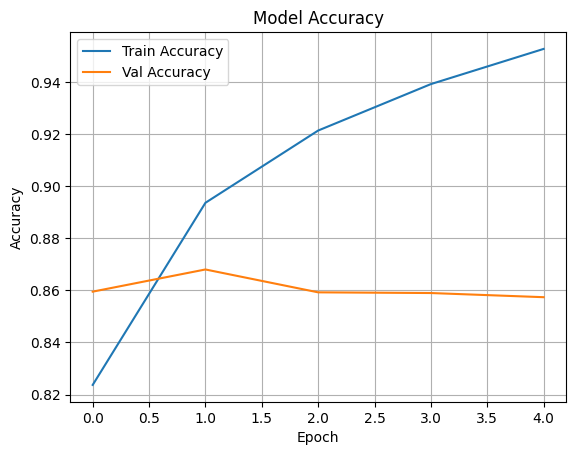

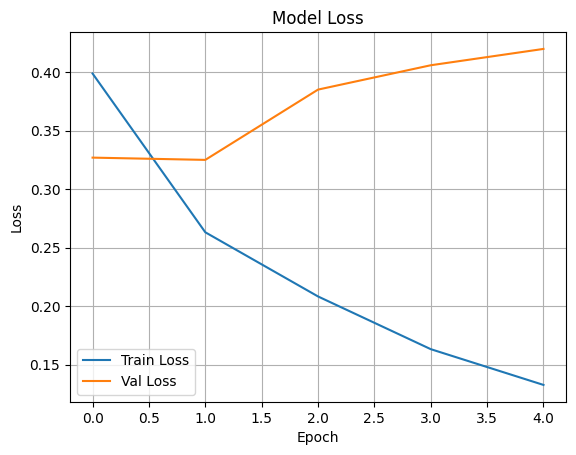

In [108]:
# Akurasi
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()